Based on: https://elitedatascience.com/keras-tutorial-deep-learning-in-python

In [1]:
import numpy as np
np.random.seed(123)  # for reproducibility

Next, we'll import the Sequential model type from Keras. This is simply a linear stack of neural network layers, and it's perfect for the type of feed-forward CNN we're building in this tutorial.

In [2]:
from keras.models import Sequential

Using TensorFlow backend.


You can either use Theano or Tensorflow as a backend. I'm using Tensorflow now.
If your backend is TF, then you should edit your ~/.keras/keras.json file

cd ~/.keras/
gedit keras.json

Then:
"image_dim_ordering": "th", 
because the data is in theano format.

Next, let's import the "core" layers from Keras. These are the layers that are used in almost any neural network:

In [3]:
from keras.layers import Dense, Dropout, Activation, Flatten

Then, we'll import the CNN layers from Keras. These are the convolutional layers that will help us efficiently train on image data:

In [4]:
from keras.layers import Convolution2D, MaxPooling2D

We import plot to visualize the model

In [5]:
from keras.utils.visualize_util import plot

In [6]:
from IPython.display import Image

Finally, we'll import some utilities. This will help us transform our data later:

In [7]:
from keras.utils import np_utils

MNIST is a great dataset for getting started with deep learning and computer vision. It's a big enough challenge to warrant neural networks, but it's manageable on a single computer.
The Keras library conveniently includes it already. We can load it like so:

In [8]:
from keras.datasets import mnist

In [9]:
# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

We can look at the shape of the dataset:

In [10]:
print X_train.shape
# (60000, 28, 28)

(60000, 28, 28)


Great, so it appears that we have 60,000 samples in our training set, and the images are 28 pixels x 28 pixels each. We can confirm this by plotting the first sample in matplotlib:

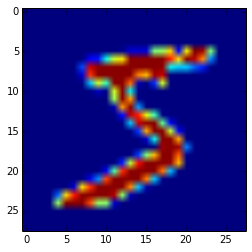

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(X_train[0])

Preprocess input data for Keras.

When using the Theano backend, you must explicitly declare a dimension for the depth of the input image. For example, a full-color image with all 3 RGB channels will have a depth of 3.

Our MNIST images only have a depth of 1, but we must explicitly declare that.

In other words, we want to transform our dataset from having shape (n, width, height) to (n, depth, width, height).

Here's how we can do that easily:

In [12]:
print(X_train.shape[0])
print(X_test.shape[0])

60000
10000


In [13]:
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

To confirm, we can print X_train's dimensions again:

In [14]:
print X_train.shape
# (60000, 1, 28, 28) Reshaping from (60000, 28, 28)

(60000, 1, 28, 28)


The final preprocessing step for the input data is to convert our data type to float32 and normalize our data values to the range [0, 1].

In [15]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Preprocess class labels for Keras.
Next, let's take a look at the shape of our class label data:

In [16]:
print y_train.shape
# (60000,)

(60000,)


Hmm... that may be problematic. We should have 10 different classes, one for each digit, but it looks like we only have a 1-dimensional array. Let's take a look at the labels for the first 10 training samples:

In [17]:
print y_train[:10]
# [5 0 4 1 9 2 1 3 1 4]

[5 0 4 1 9 2 1 3 1 4]


And there's the problem. The y_train and y_test data are not split into 10 distinct class labels, but rather are represented as a single array with the class values.

We can fix this easily:

In [18]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [19]:
print Y_train.shape
# (60000, 10)

(60000, 10)


In [20]:
print Y_train[:3,:]

[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


Define model architecture. Let's start by declaring a sequential model format:

In [21]:
model = Sequential()

Next, we declare the input layer:

In [22]:
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(1,28,28)))

The input shape parameter should be the shape of 1 sample. In this case, it's the same (1, 28, 28) that corresponds to  the (depth, width, height) of each digit image.

But what do the first 3 parameters represent? They correspond to the number of convolution filters to use (32), the number of rows in each convolution kernel (3), and the number of columns in each convolution kernel (3), respectively.

*Note: The step size is (1,1) by default, and it can be tuned using the 'subsample' parameter.

We can confirm this by printing the shape of the current model output:

In [23]:
print model.output_shape
# (None, 32, 26, 26)

(None, 32, 26, 26)


Next, we can simply add more layers to our model like we're building legos:

In [24]:
model.add(Convolution2D(32, 3, 3, activation='relu'))
print model.output_shape

(None, 32, 24, 24)


In [25]:
model.add(MaxPooling2D(pool_size=(2,2)))
print model.output_shape

(None, 32, 12, 12)


In [26]:
model.add(Dropout(0.25))
print model.output_shape

(None, 32, 12, 12)


Again, we won't go into the theory too much, but it's important to highlight the Dropout layer we just added. This is a method for regularizing our model in order to prevent overfitting. 

MaxPooling2D is a way to reduce the number of parameters in our model by sliding a 2x2 pooling filter across the previous layer and taking the max of the 4 values in the 2x2 filter.

So far, for model parameters, we've added two Convolution layers. To complete our model architecture, let's add a fully connected layer and then the output layer:

In [27]:
model.add(Flatten())
print model.output_shape
# 4608=32*12*12

(None, 4608)


In [28]:
model.add(Dense(128, activation='relu'))
print model.output_shape

(None, 128)


In [29]:
model.add(Dropout(0.5))
print model.output_shape

(None, 128)


In [30]:
model.add(Dense(10, activation='softmax'))
print model.output_shape

(None, 10)


For Dense layers, the first parameter is the output size of the layer. Keras automatically handles the connections between layers.

Note that the final layer has an output size of 10, corresponding to the 10 classes of digits.

Also note that the weights from the Convolution layers must be flattened (made 1-dimensional) before passing them to the fully connected Dense layer.

Let us plot the model we have so far:

In [31]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 26, 26)    320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 24, 24)    9248        convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 12, 12)    0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 32, 12, 12)    0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [32]:
plot(model, show_shapes=True, to_file='model.png')

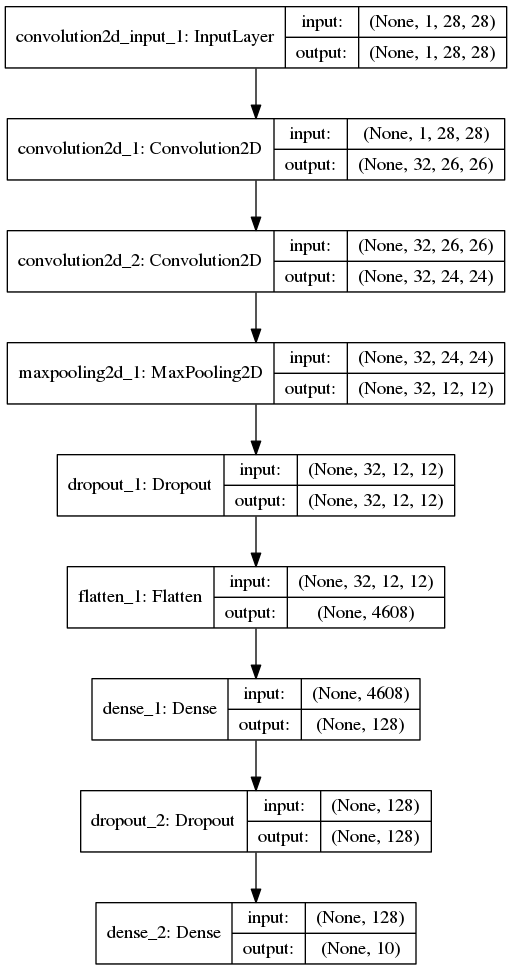

In [33]:
Image("model.png")

Compile model.

We just need to compile the model and we'll be ready to train it. When we compile the model, we declare the loss function and the optimizer (SGD, Adam, etc.). Keras has a variety of loss functions and out-of-the-box optimizers to choose from.

In [34]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Fit model on training data.
To fit the model, all we have to do is declare the batch size and number of epochs to train for, then pass in our training data.

In [35]:
model.fit(X_train, Y_train, 
          batch_size=32, nb_epoch=5, verbose=1)

Epoch 1/5
60000/60000 [==============================] - 21s - loss: 0.2086 - acc: 0.9368    
Epoch 2/5
60000/60000 [==============================] - 18s - loss: 0.0913 - acc: 0.9728    
Epoch 3/5
60000/60000 [==============================] - 18s - loss: 0.0693 - acc: 0.9790    
Epoch 4/5
60000/60000 [==============================] - 19s - loss: 0.0570 - acc: 0.9823    
Epoch 5/5
60000/60000 [==============================] - 18s - loss: 0.0497 - acc: 0.9846    


You can also use a variety of callbacks to set early-stopping rules, save model weights along the way, or log the history of each training epoch.

Evaluate model on test data.
Finally, we can evaluate our model on the test data:

In [36]:
score = model.evaluate(X_test, Y_test, verbose=0)

In [37]:
score

[0.029840270959777992, 0.99029999999999996]